In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from bigdatavqa.coreset import Coreset
from bigdatavqa.datautils import DataUtils


In [7]:
number_of_qubits = 10
circuit_depth = 1
max_shots = 1000
max_iterations = 100
data_location = "../data"
number_of_coresets_to_evaluate = 15
number_of_sampling_for_centroids = 20

### Load data

In [4]:
data_utils = DataUtils(data_location)
raw_data = data_utils.load_dataset()

Data loaded from ../data/dataset.pickle


### Run the experiment

In [8]:
coreset = Coreset(raw_data, number_of_sampling_for_centroids, number_of_qubits, number_of_coresets_to_evaluate)
coreset_vectors, coreset_weights = coreset.get_best_coresets()



Using BFL16 method to generate coresets


/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

In [14]:
coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df['weights'] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,1.234970,-2.322804,30.756221,A
1,7.632561,1.608484,46.346699,B
2,-1.401513,1.381436,72.090693,C
3,-0.955183,0.605138,78.576072,D
4,7.031164,0.600513,207.344587,E
5,-0.579997,0.531602,129.503659,F
6,5.598487,2.381436,79.214885,G
7,1.437617,-0.720174,123.906885,H
8,-1.374061,1.006438,120.753605,I
9,1.583383,-0.964323,129.192044,J


In [32]:
# TODO: show example as the follow

divisive_clustering_function = DivisiveClusteringVQE(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=threshold_for_max_cut,
)

divisive_clustering_function = DivisiveClusteringMaxCut()


hierrachial_sequence = get_divisive_sequence(coreset_df, divisive_clustering_function)

# divisive_clustering_function = DivisiveClusteringRandom()

# divisive_clustering_function = DivisiveClusteringKMeans

# hierrachial_sequence_kmeans = get_divisive_sequence(
#     coreset_df, divisive_clustering_function
# )

In [33]:
DC = DivisiveClustering(coreset_df, number_of_clusters=2, max_iterations=100, threshold=0.1)

In [34]:
DC.clustering()

ValueError: Variable qubits not found in the object

### Investigate corest

In [5]:
from bigdatavqa.coreset import Coreset
hc = pd.read_pickle("hc.pkl")
coreset = Coreset()
coresets =  coreset.get_best_coresets(
    data_vectors=raw_data,
    number_of_runs=number_of_centroid_evaluation,
    coreset_size=number_of_qubits,
    number_of_coresets_to_evaluate=number_of_corsets_to_evaluate,
)

In [50]:
pd.to_pickle(coresets_pd, "coresets_pd.pkl")

In [49]:
coresets_pd = pd.DataFrame(coresets[0])
coresets_pd.columns = ["X", "Y"]
coresets_pd['weights'] = coresets[1]
coresets_pd['X_norm'] = normalize_np(coresets_pd['X'], centralize=True)
coresets_pd['Y_norm'] = normalize_np(coresets_pd['Y'], centralize=True)
coresets_pd['weights_norm'] = normalize_np(coresets_pd['weights'])
coresets_pd['name'] = [chr(65 + i) for i in range(len(coresets_pd))]
coresets_pd

,X,Y,weights,X_norm,Y_norm,weights_norm,name
0,-0.730637,0.560738,141.930948,-0.752247,0.069486,0.408902,A
1,8.400117,-0.716623,34.704424,0.572735,-0.733969,0.099983,B
2,6.625932,1.590019,347.102776,0.315279,0.716901,1.000000,C
3,8.809205,-0.260701,30.625510,0.632098,-0.447196,0.088232,D
4,8.414999,-0.018913,81.934644,0.574894,-0.295112,0.236053,E
5,4.997290,2.040100,111.374199,0.078944,1.000000,0.320868,F
6,1.976289,-0.865133,94.424112,-0.359439,-0.827382,0.272035,G
7,-2.437962,1.259981,37.851261,-1.000000,0.509308,0.109049,H
8,0.551607,-0.270315,122.921489,-0.566178,-0.453243,0.354136,I
9,7.925852,1.183509,123.123136,0.503913,0.461207,0.354717,J


Explain how coreset vectors and weights are normalized

Text(0.5, 1.0, 'Visualizing raw data and the corresponding coreset')

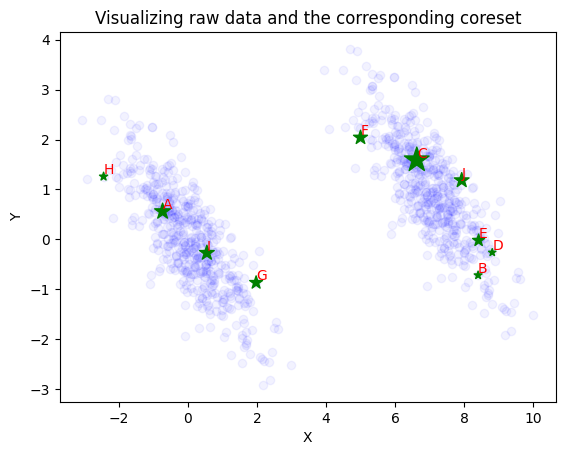

In [7]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color = 'blue', alpha=0.05)
plt.scatter(coresets_pd.X, coresets_pd.Y, s = coresets_pd.weights, marker='*', color = 'green')
for idx, row in coresets_pd.iterrows():
    plt.annotate(row["name"], xy = (row.X, row.Y+ 0.05), color = "red")

plt.xlabel("X")
plt.ylabel("Y")

plt.title("Visualizing raw data and the corresponding coreset")


Draw an expected Dendrogram

### Plot dendrogram

Given that there are no automated functions to plot the dendrogram, we need to do this manually. We plot the dendrogram at each step of the hierarchy. If we are satisfied with the result, we move to the next index. 

#### Step by step guide:
1. Enter the index value. If you are starting, this should be 0. The max value is the total length of the ```hc``` list.
2. It will prompt buffer values. Enter two values with opposite signs separated by space. i.e -500 500.
3. The system will prompt a question asking for your satisfaction. Since this function is created for terminal, doing it on notebook is a bit tricky. You have to say "yes" to view the plot.
4. If you are satisfied with the position of the branches. Repeat the previous steps with the next index
5. The file saved in this process will be used to plot the final dendrogram

#### Tips
1. The buffer value must be high initially and slowly decrease the value. This ensures that there are enough room for upcoming branches
2. Try to place the branch with a low number of children towards the y=0 axis. 

In [9]:
#hc = pd.read_pickle("../paper_results/data/divisive_clustering/hc_vqe_cut.pkl")
dendo = Dendrogram(hc, coresets_pd, raw_data, dendrogram_file = "example")

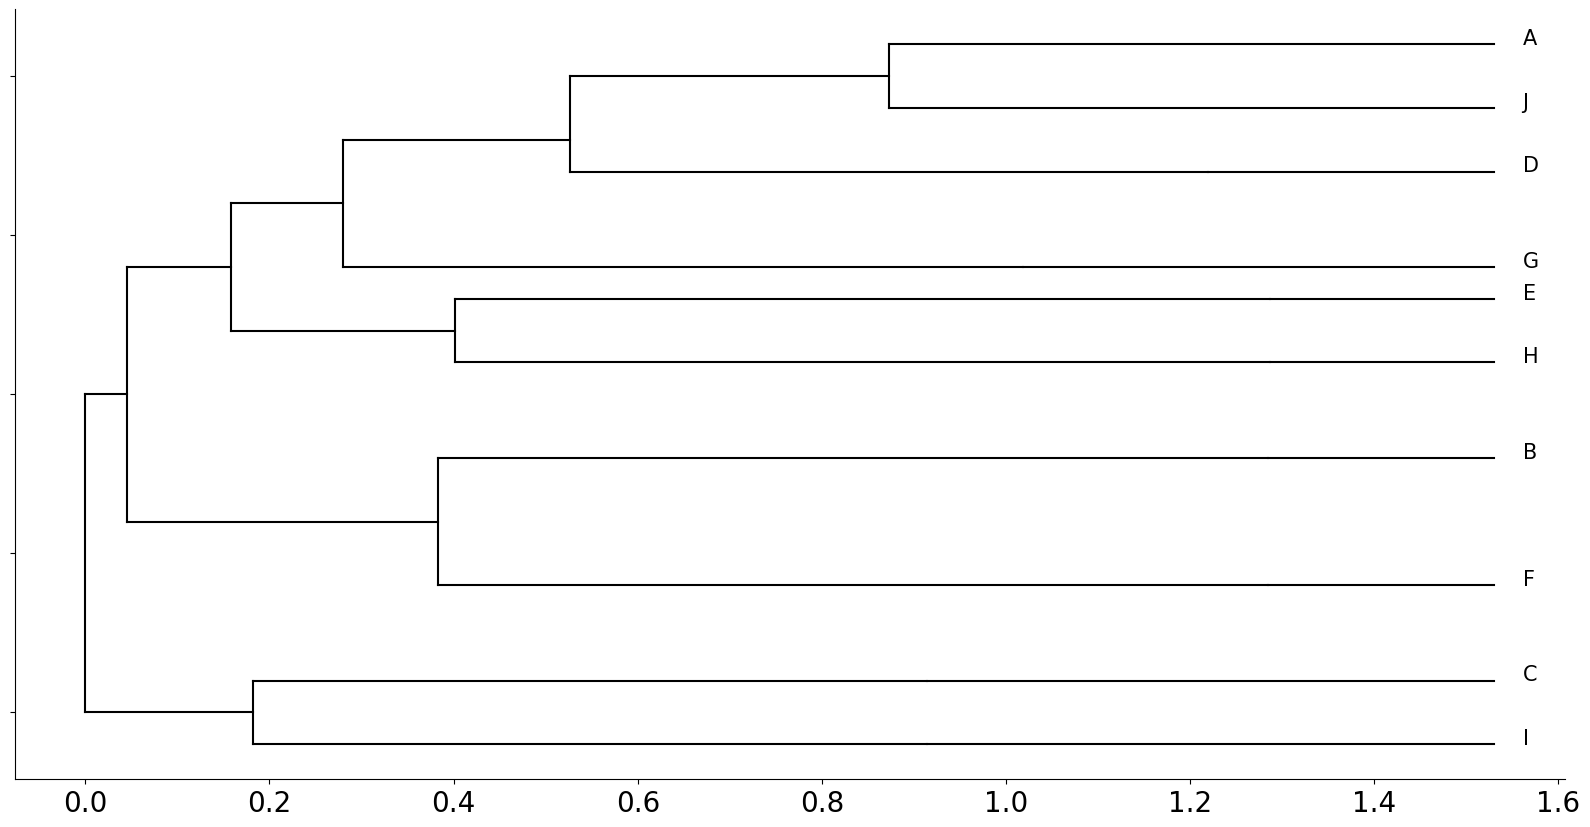

In [38]:
current_index = 18

dendo.plot_dendrogram_manually(current_index, save_image = False)

### Final dendrogram

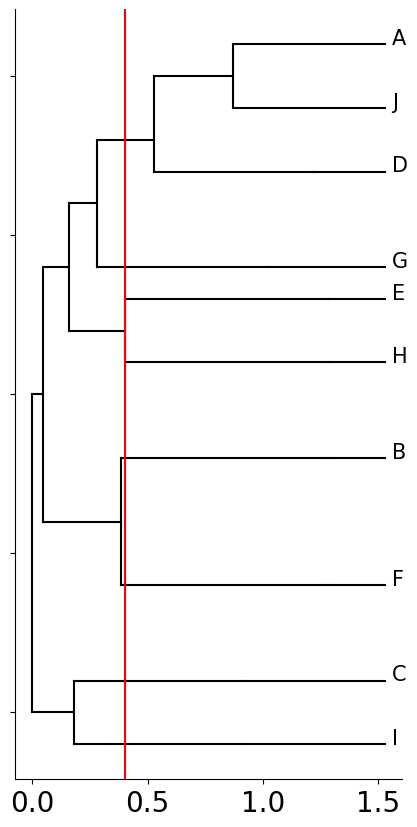

In [39]:
dendrogram_df = pd.read_pickle(
    "example.pkl"
)
dendo.plot_dendrogram(
    dendrogram_df=dendrogram_df,
    plot_name=f"example.png",
    vertical_line=0.4,
)


### Calculating the total cost

In [42]:
centroid_coords = dendo.get_centroid_coords()

cost_list = get_divisive_cluster_cost(dendo, hc, centroid_coords)

vqe_cost = sum(cost_list)

print(f"VQE cost: {vqe_cost}")

VQE cost: 49.63362850037852


### Hierarchial division through other methods
Available methods are "kmeans", "maxcut" and "random"

In [90]:
hc = perform_bruteforce_divisive_clustering(coresets_pd, method = "random")
dendo = Dendrogram(hc, coresets_pd, raw_data)
dendo.get_centroid_dist_df()
dendo.get_cluster_reference_dict()

centroid_coords = dendo.get_centroid_coords()

cost_list = get_divisive_cluster_cost(dendo, hc, centroid_coords)
random_cost = sum(cost_list)
print(f"Random cost: {random_cost}")

Random cost: 46.0796004455678


In [94]:
hc = perform_bruteforce_divisive_clustering(coresets_pd, method = "kmeans")
dendo = Dendrogram(hc, coresets_pd, raw_data)
dendo.get_centroid_dist_df()
dendo.get_cluster_reference_dict()

centroid_coords = dendo.get_centroid_coords()

cost_list = get_divisive_cluster_cost(dendo, hc, centroid_coords)
kmeans_cost = sum(cost_list)
print(f"Kmeans cost: {kmeans_cost}")

Kmeans cost: 54.423574755067484


In [48]:
coresets_pd = coresets_pd.drop(columns = ["X", "Y", "weights"])
hc = perform_bruteforce_divisive_clustering(coresets_pd, method = "maxcut")
dendo = Dendrogram(hc, coresets_pd, raw_data)
dendo.get_centroid_dist_df()
dendo.get_cluster_reference_dict()

centroid_coords = dendo.get_centroid_coords()

cost_list = get_divisive_cluster_cost(dendo, hc, centroid_coords)
max_cut_cost = sum(cost_list)
print(f"Maxcut cost: {max_cut_cost}")

  0%|          | 0/1022 [00:00<?, ?it/s]

100%|██████████| 1022/1022 [00:00<00:00, 4896.74it/s]


ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

## Visualizing the cost output

In [ ]:
# Define the cost values
cost_values = [random_cost, vqe_cost, kmeans_cost, max_cut_cost]

# Define the labels for the x-axis
labels = ['Random Cluster','VQE', 'K-means', 'Brute Force']

# Create the bar chart
plt.bar(labels, cost_values)

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Cost Value')
plt.title('Cost Values Comparison (Lower is better)')

# Display the chart
plt.show()